# Model evaluation on SUVI test data
In this notebook, we provide code to predict SCSS-Net coronal holes on test dataset SUVI and evaluate it's metrics

In [ ]:
!pip install opencv-python-headless

In [2]:
import sys, os
sys.path.append('../src/')
import glob
import numpy as np
from datetime import datetime
from PIL import Image
import matplotlib.pylab as plt
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
import tensorflow
from keras.callbacks import ModelCheckpoint
from model_scss_net import scss_net
from metrics import dice_np, iou_np, dice, iou
from utils import plot_imgs, plot_metrics, plot_top


In [3]:
# define hyperparameters needed for training
IMG_SIZE = 256  # resize imgs to 256x256
BATCH_SIZE = 8 # set batch size
SEED = 42       # set seed for reproducibility
EPOCHS = 100    # Set number of epochs

# specify model filename, you should rewrite MODEL_NAME as yours preferrings
MODEL_NAME = "model_CH_SUVI"
model_filename = f"{MODEL_NAME}.h5" 

In [4]:
imgs_test = sorted(glob.glob("../data/test_SUVI/imgs/*.png"))
masks_test = sorted(glob.glob("../data/test_SUVI/masks/*.png"))

print(f"Imgs number = {len(imgs_test)}\nMasks number = {len(masks_test)}")

Imgs number = 5214
Masks number = 5214


In [5]:
imgs_test_list = []
masks_test_list = []
for image, mask in zip(imgs_test, masks_test):
    imgs_test_list.append(np.array(Image.open(image).convert("L").resize((IMG_SIZE, IMG_SIZE))))
    masks_test_list.append(np.array(Image.open(mask).convert("L").resize((IMG_SIZE, IMG_SIZE))))

In [6]:
# Normalization from (0; 255) to (0; 1)
x_test = np.asarray(imgs_test_list, dtype=np.float32)/255
y_test = np.asarray(masks_test_list, dtype=np.float32)/255
print("Before Reshape - x_test shape:", x_test.shape)
print("Before Reshape - y_test shape:", y_test.shape)

# Reshape to (n_imgs, height, width, channels)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 1)

Before Reshape - x_test shape: (5214, 256, 256)
Before Reshape - y_test shape: (5214, 256, 256)


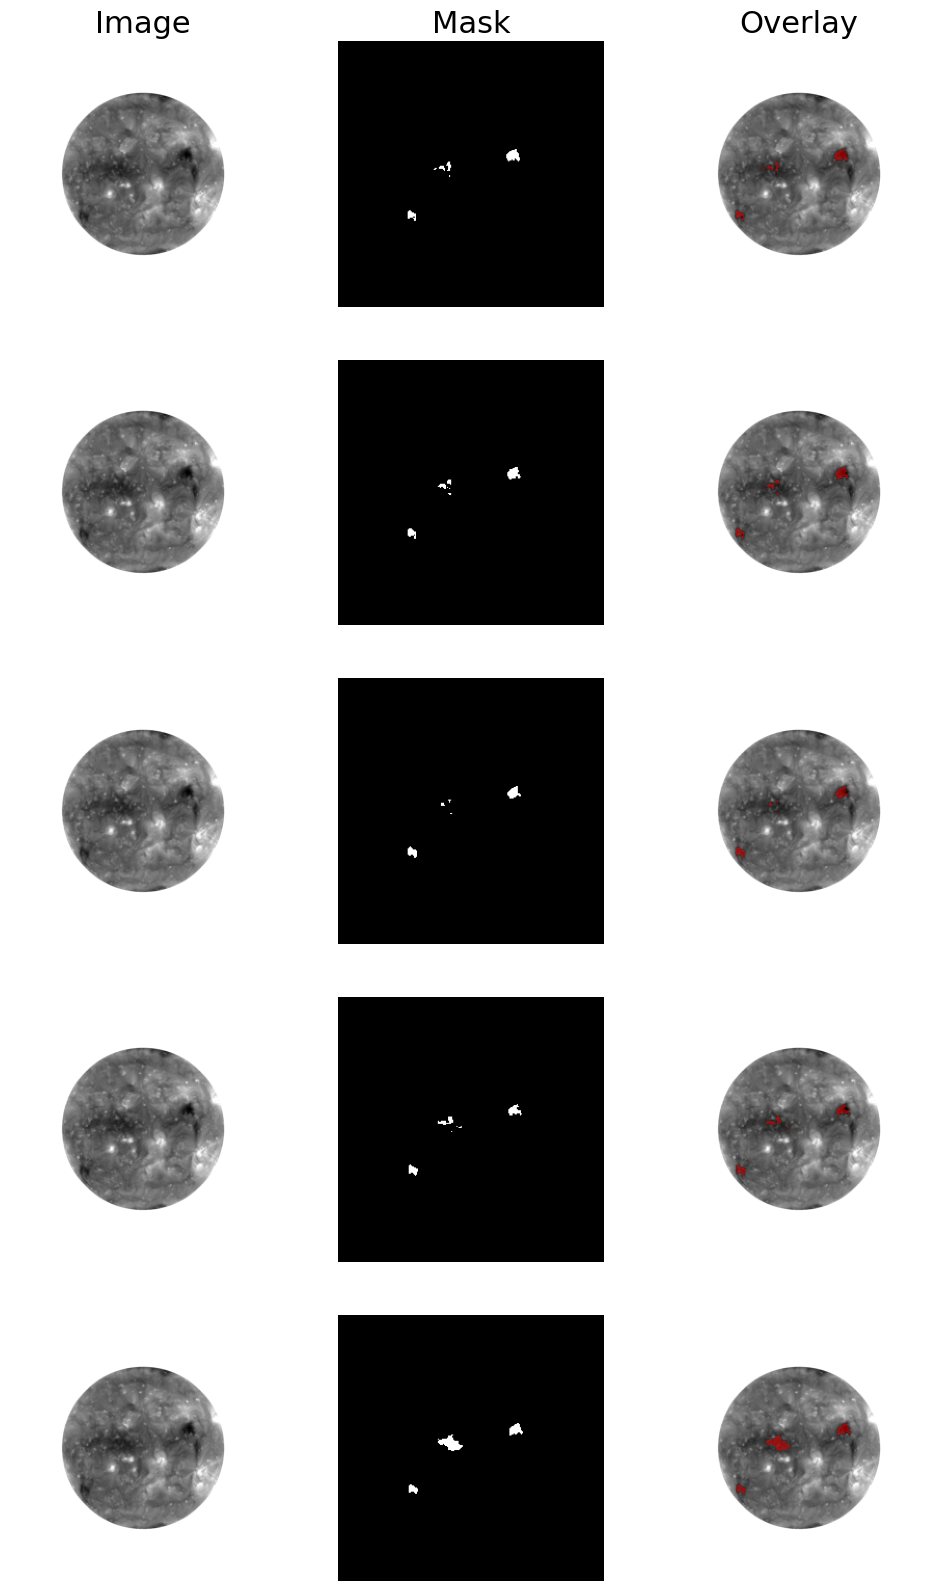

In [7]:
# show images with coresponding mask
plot_imgs(imgs=x_test, masks=y_test, n_imgs=5).show()

In [8]:
# input shape should be (256, 256, 1)
input_shape = x_test[0].shape
print(f"Input shape: {input_shape}\n")

Input shape: (256, 256, 1)



In [ ]:
# Load model architecture with optimal parameteres
model = scss_net( 
    input_shape,
    filters=32,       
    layers=4,
    batch_norm=True,
    drop_prob=0.5)

# Compile model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",  
    metrics=[iou, dice])

In [10]:
model.load_weights(model_filename)

In [11]:
y_pred = model.predict(x_test)

2024-03-19 19:42:24.552646: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


163/163 [==============================] - 75s 429ms/step


## METRICS

In [12]:
y_pred_bin = np.where(y_pred > 0.5, 1, 0)  # Set threshold for predicted values

dice = np.round(dice_np(y_test, y_pred), 4)
iou_test = np.round(iou_np(y_test, y_pred), 4)

dice_tresh = np.round(dice_np(y_test, y_pred_bin), 4)
iou_test_tresh = np.round(iou_np(y_test, y_pred_bin), 4)

print(f"Test:\nDice: {dice} Dice_tresh: {dice_tresh}\n IoU: {iou_test} IoU_tresh: {iou_test_tresh}\n")

Test:
Dice: 0.9204 Dice_tresh: 0.9566
 IoU: 0.8525 IoU_tresh: 0.9167



## GRAPH FOR TEST SET

In [13]:
dates = []
for name in sorted(glob.glob("../test_SUVI/imgs/*.png")):
    name_clean = name[-45:]
    tostrip = name_clean[0:8]
    date = datetime.strptime(tostrip, '%Y%m%d')
    dates.append(date)

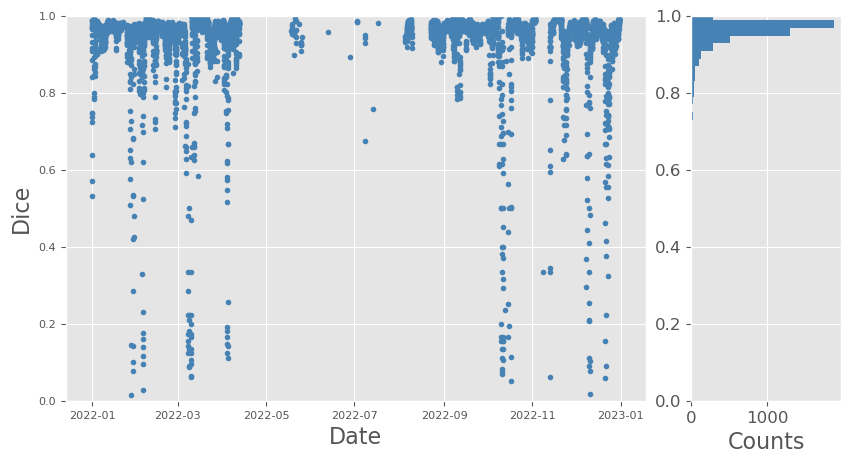



The Dice score is higher than 0.5 for 97.85% of images in test set.
The number of images with dice between 0 and 0.1 is: 19
The number of images with dice between 0.1 and 0.2 is: 40
The number of images with dice between 0.2 and 0.3 is: 18
The number of images with dice between 0.3 and 0.4 is: 14
The number of images with dice between 0.4 and 0.5 is: 14
The number of images with dice between 0.5 and 0.6 is: 31
The number of images with dice between 0.6 and 0.7 is: 55
The number of images with dice between 0.7 and 0.8 is: 103
The number of images with dice between 0.8 and 0.9 is: 307
The number of images with dice between 0.9 and 1.0 is: 4339


In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

dice = [dice_np(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred_bin)]
intervals = [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 0.4), (0.4, 0.5), (0.5, 0.6), (0.6, 0.7), (0.7, 0.8), (0.8, 0.9), (0.9, 1.0)]
counts = []
for interval in intervals:
    lower, upper = interval
    count = len([i for i in dice if lower <= i < upper])
    counts.append(count)

plt.style.use('ggplot')
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(20, 20)
ax_scatter = fig.add_subplot(gs[0:20, 0:15])
ax_hist_x = fig.add_subplot(gs[0:20, 16:20])
ax_scatter.set_xlabel("Date", fontsize=16)
ax_scatter.set_ylabel("Dice", fontsize=16)
ax_scatter.tick_params(axis='both', which='major', labelsize=8)
ax_hist_x.set_xlabel("Counts", fontsize=16)
ax_hist_x.tick_params(axis='both', which='major', labelsize=12)
ax_scatter.set_ylim([0, 1])
ax_hist_x.set_ylim([0, 1])
ax_scatter.plot(dates, dice, '.', label=f'Averaged Dice for SCSS-Net = {dice}', color='steelblue')
ax_hist_x.hist(dice, orientation='horizontal', bins=100, color='steelblue')
plt.show()

print("\n")
print(f'The Dice score is higher than 0.5 for {round(len([i for i in dice if i > 0.5])/len(dice)*100,2)}% of images in test set.')

for idx, interval in enumerate(intervals):
    lower, upper = interval
    print(f'The number of images with dice between {lower} and {upper} is: {counts[idx]}')


## Plotting figs
following output for coronal holes has been saved to ../figures/Model_SUVI_predicted.png and shown in markdown cell bellow

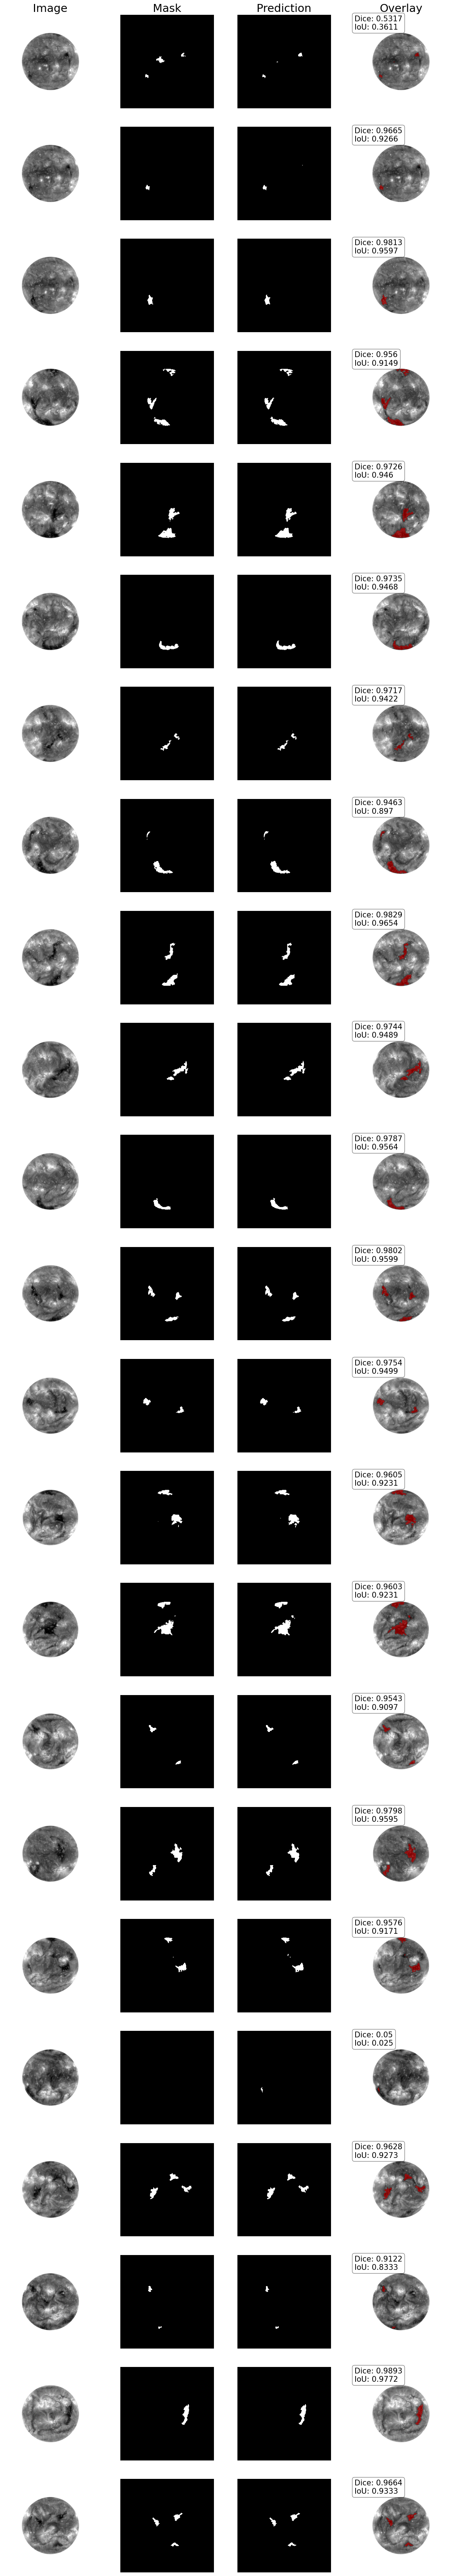

In [13]:
save_plot(imgs=x_test, masks=y_test, predictions=y_pred_thresholded, n_imgs=23, filename='Model_SUVI_predicted.png')